# Named entity recognition model built in keras, trained on putput utterances and tokens

This notebook demonstrates using putput to generate data and train a named entity recognition model. Specifically, the notebook considers the scenario in which customers place orders at a restaurant. Labels follow the <a href="https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)">IOB2 format</a>.

For instance, given a customer's utterance:
* "can i have a chicken sandwich please and remove the coke"

the model should output the tokens
* "B-ADD_TO_ORDER I-ADD_TO_ORDER I-ADD_TO_ORDER B-QUANTITY B-ITEM I-ITEM O B-REMOVE B-QUANTITY B-ITEM".

and the groups

* "B-ADD_INTENT I-ADD_INTENT I-ADD_INTENT I-ADD_INTENT I-ADD_INTENT I-ADD_INTENT O B-REMOVE_INTENT I-REMOVE_INTENT I-REMOVE_INTENT".

where "B-" indicates the beginning of a chunk, "I-" indicates inside a chunk, and "O-" indicates outside a chunk. In this scenario "can i have" is an ADD_TO_ORDER chunk, "a" is a QUANTITY chunk, and "please" is not part of any chunk.

This notebook borrows heavily from [an awesome blog series on deep learning for named entity recognition](https://www.depends-on-the-definition.com/guide-sequence-tagging-neural-networks-python/).

**If you would like to run this notebook yourself, you will need a GPU for training the LSTM.**

In [1]:
import itertools
import os
import random
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import randomcolor
import spacy
from keras.layers import (LSTM, Bidirectional, Dense, Dropout, Embedding, TimeDistributed)
from keras.models import Input, Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras_tqdm import TQDMNotebookCallback
from seqeval.metrics import classification_report
from sklearn.model_selection import train_test_split
from spacy import displacy

from putput import ComboOptions, Pipeline

Using TensorFlow backend.


# Define Environment variables

In [2]:
MAX_SAMPLE_SIZE = 3000
EPOCHS = 2
BATCH_SIZE = 64
random.seed(1)

# Ignore this, used for running continuous integration quickly
if os.environ.get('CI'):
    CI_DATA_SIZE = 10
    EPOCHS = 1

In [3]:
try:
    pattern_def_path = Path(os.path.dirname(os.path.abspath(__file__))) / "patterns.yml"
    putput_model_path = Path(os.path.dirname(os.path.abspath(__file__))) / 'multiple_output_lstm_custom_word_emb.h5'
except NameError:
    pattern_def_path = Path(os.getcwd()) / "patterns.yml"
    putput_model_path = Path(os.getcwd()) / 'multiple_output_lstm_custom_word_emb.h5'

In [4]:
def random_color_dict(tags, seed=0):
    rand_color = randomcolor.RandomColor(seed=seed)
    colors = rand_color.generate(count=len(tags), luminosity='light')
    return dict(zip(tags, colors))

In [5]:
def clean_bio_tag(tag):
    if tag.startswith('I-') or tag.startswith('B-'):
        return tag[2:]
    return tag

In [6]:
def to_visualizer(words, tags, title):
    current_letter_index = 0
    ents = []
    for word, tag in zip(words, tags): 
        if tag[0] == 'I' and len(ents) > 0:
            ents[-1]['end'] += len(word) + 1
        else:
            ent = {'start': current_letter_index,
                   'end': current_letter_index + len(word) + 1,
                   'label': tag.split('-')[-1]}
            ents.append(ent)
        current_letter_index += len(word) + 1
    return {'text': ' '.join(words),
           'ents': ents,
           'title': title}

In [7]:
def display_sentence(utterance, tokens, groups, options, suffix=''):
    sentence_visualizer = {'text': ' '.join(utterance), 'ents': [], 'title': 'SENTENCE' + suffix}
    token_visualizer = to_visualizer(utterance, tokens, 'TOKENS')
    group_visualizer = to_visualizer(utterance, groups, 'GROUPS')
    displacy.render([sentence_visualizer, token_visualizer, group_visualizer], style='ent', manual=True, jupyter=True, options=options)

In [8]:
def display_sentences(utterances, utterance_tokens, utterance_groups, options, sample_size):
    indicies = random.sample(range(0, len(utterances)), sample_size)
    for sample_index in indicies:
        display_sentence(utterances[sample_index],
                         utterance_tokens[sample_index],
                         utterance_groups[sample_index],
                         options,
                         suffix=' {}:'.format(sample_index))
        print()

# How to use putput

### 1) Pattern definition file:
let's take a look at our pattern definition file 

In [9]:
if not os.environ.get('CI'):
    ! cat "{str(pattern_def_path)}"

base_tokens:
  - SUBJECT_PERSONAL_PRONOUN: [i, he, she, we, they]
  - OBJECT_PERSONAL_PRONOUN: [me, him, her, us]
  - SUBJECT_PERSONAL_PRONOUN_IS: [i'm, i am, he is, he's, she is, she's, they are, they're,
                                  we are, we're, everyone is, everyone's, everbody is,
                                  everbody's, everything is, everything's]
token_patterns:
  - static:
    - ADD:
      - [[can, may, could], SUBJECT_PERSONAL_PRONOUN, [get, have, order, take, do]]
      - [SUBJECT_PERSONAL_PRONOUN, ["'d", "'ll"], [like, have, take, get, want, need, order]]
      - [[set, hook], OBJECT_PERSONAL_PRONOUN, [up with]]
      - [[give, order], OBJECT_PERSONAL_PRONOUN]
      - [SUBJECT_PERSONAL_PRONOUN, ["'d", "'ll"], [like, have, want, need],
         [to get, to have, to take, to order, to do]]
      - [SUBJECT_PERSONAL_PRONOUN, 
         [need, would need, will need, would like, would want, want, will have, will want],
         [to get, to have, to take, to order, to d

  - [ADD_ADD_ITEMS_QUANTITY, CONJUNCTION,  SUBSTITUTE_ITEM_FOR_ITEM]
  - [ADD_ADD_ITEMS_QUANTITY, SUBSTITUTE_ITEM_QUANTITY_SIZE]
  - [ADD_ADD_ITEMS_QUANTITY, CONJUNCTION, SUBSTITUTE_ITEM_SIZE]
  - [ADD_ADD_ITEMS_QUANTITY, SUBSTITUTE_POSITION_FOR_ITEM]
  - [ADD_ADD_ITEMS_CONJUNCTION_QUANTITY_ITEM, SUBSTITUTE_POSITION_FOR_ITEM]
  - [ADD_ADD_ITEMS_QUANTITY, SUBSTITUTE_PRONOUN_FOR_ITEM]
  - [ADD_ADD_ITEMS_QUANTITY, SUBSTITUTE_ITEM]
  - [SUBSTITUTE_ITEM_FOR_ITEM, CONJUNCTION, ADD_ADD_ITEM_QUANTITY, CONJUNCTION, REMOVE_ITEM]


### 2) Define dynamic tokens:
In the real world the items would most likely be pulled in from some menu service and inserted here, but you get the idea.

In [10]:
dynamic_token_patterns_map = {
  "ITEM": ((("burger", "hamburger", "coke", "french fries", "chicken sandwich", "ten chicken strips"),),),
  "QUANTITY": ((("a", "no", "extra", "the", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten"),),),
}

### 3) [Optional] Define combination options

In [11]:
# Define how we want to generate utterances and sample size. More info here:
# https://github.com/michaelperel/putput/blob/00877147373690f8cc6ad16f164c2a44ba728c62/putput/joiner.py#L17
combo_options_map = {
    'DEFAULT': ComboOptions(max_sample_size=MAX_SAMPLE_SIZE, with_replacement=True, seed=0)
}

### 4) [Optional] Define expansion hooks, combination hooks, or final hooks:

In [12]:
# This function buckets groups into either REMOVE, SUBSTITUTE, ADD, or None.
# We do this because a lot of the groups overlap so we want to put them into general groupings
def _generalize_groups(utterance, handled_tokens, handled_groups):
    new_handled_groups = []
    for groups in handled_groups:
        new_groups = []
        for group in groups.split():
            prefix = ''
            if '-' in group:
                prefix = group[:2]
            if 'REMOVE' in group:
                new_groups.append(prefix + 'REMOVE')
            elif 'SUBSTITUTE' in group:
                new_groups.append(prefix +'SUBSTITUTE')
            elif 'None' in group:
                new_groups.append('None')
            else:
                new_groups.append(prefix + 'ADD')
        new_handled_groups.append(' '.join(new_groups))
    return utterance, handled_tokens, new_handled_groups

In [13]:
# This function converts the final output to lists of words, tokens, and groups.
def _output_to_lists(utterance, tokens, groups):
    return utterance.replace(" '", "'").split(), ' '.join(tokens).split(), ' '.join(groups).split()

In [14]:
combo_hooks_map = {
    'DEFAULT': (_generalize_groups,_output_to_lists)
}

### 5) Create and use putput pipeline to generate utterances, tokens, and groups:

In [15]:
def compute_utterances_and_tokens_and_groups(pattern_def_path): 
    # We choose the IOB preset for use in training a Named Entity Recognition model
    iob_pipeline = Pipeline.from_preset('IOB2',
                                         pattern_def_path,
                                         dynamic_token_patterns_map=dynamic_token_patterns_map,
                                         combo_options_map=combo_options_map,
                                         combo_hooks_map=combo_hooks_map,
                                        )
    
    # putput outputs to a generator for efficient use of memory 
    iob_generator = iob_pipeline.flow(disable_progress_bar=True)
    
    # Ignore this, used for running continuous integration
    if os.environ.get('CI'):
        iob_generator = itertools.islice(iob_generator, CI_DATA_SIZE)
    
    # Unpack generator
    utterances, utterance_tokens, utterance_groups = zip(*iob_generator)
    return utterances, utterance_tokens, utterance_groups

In [16]:
utterances, utterance_tokens, utterance_groups = compute_utterances_and_tokens_and_groups(pattern_def_path)
print('Generated: {} utterances and {} tokens and {} groups'.format(len(utterances), len(utterance_tokens), len(utterance_groups)))

Generated: 366000 utterances and 366000 tokens and 366000 groups


In [17]:
print(utterances[0])
print(utterance_tokens[0])
print(utterance_groups[0])

['french', 'fries', 'french', 'fries', 'ten', 'chicken', 'strips', 'coke']
['B-ITEM', 'I-ITEM', 'B-ITEM', 'I-ITEM', 'B-ITEM', 'I-ITEM', 'I-ITEM', 'B-ITEM']
['B-ADD', 'I-ADD', 'I-ADD', 'I-ADD', 'I-ADD', 'I-ADD', 'I-ADD', 'I-ADD']


## [Optional] Displacy

In [18]:
# [OPTIONAL] This is just for making displacy pretty with a color map
# we generate a tag to color dictionary for displacy to use
unique_tokens = set([clean_bio_tag(token) for tokens in utterance_tokens for token in tokens])
unique_groups = set([clean_bio_tag(group) for groups in utterance_groups for group in groups])
unique_tags = list(unique_tokens | unique_groups)
color_dict = random_color_dict(unique_tags, seed=1)
displacy_options = {'ents': unique_tags, 'colors': color_dict}

In [19]:
display_sentences(utterances, utterance_tokens, utterance_groups, displacy_options, 5)

# Using putput for Named Entity Recognition (keras)

In [20]:
def compute_word2idx(utterances):
    words = list(set(list(itertools.chain.from_iterable(utterances))))
    words.append("ENDPAD")
    words.append("UNKNOWN")
    word2idx = {w: i for i, w in enumerate(words)}
    return word2idx

In [21]:
def compute_tag2idx(tokens):
    tags = list(set(list(itertools.chain.from_iterable(tokens))))
    if 'O' not in tags:
        tags.append('O')
    tag2idx = {t: i for i, t in enumerate(tags)}
    return tag2idx

In [22]:
def plot_histogram_length_of_utterances(utterances):
    plt.hist([len(utterance) for utterance in utterances], bins=50)
    plt.show()

In [23]:
def transform_utterances_for_keras(utterances, max_utterance_length, word2idx):
    X = [[(word2idx.get(word) or word2idx.get("UNKNOWN")) for word in phrase] for phrase in utterances]
    X = pad_sequences(maxlen=max_utterance_length, sequences=X, padding="post", value=word2idx['ENDPAD'])
    return X

In [24]:
def transform_tokens_for_keras(tokens, max_utterance_length, tag2idx):
    y = [[tag2idx[tag] for tag in token] for token in tokens]
    y = pad_sequences(maxlen=max_utterance_length, sequences=y, padding="post", value=tag2idx["O"])
    y = [to_categorical(i, num_classes=len(tag2idx)) for i in y]
    return y

In [25]:
def train_test(utternaces, tokens, groups):
    return train_test_split(utternaces, tokens, groups, test_size=0.1, random_state=1)

In [26]:
def define_and_compile_model(max_utterance_length, num_unique_words, num_unique_tags, num_unique_groups):
    # bidirectional LSTM with custom word embeddings
    input = Input(shape=(max_utterance_length,))
    model = Embedding(input_dim=num_unique_words, output_dim=16, input_length=max_utterance_length)(input)
    model = Dropout(0.1)(model)
    model = Bidirectional(LSTM(units=16, return_sequences=True, recurrent_dropout=0.2))(model)
    token_output = TimeDistributed(Dense(num_unique_tags, activation="softmax"), name='token_output')(model)  # softmax output layer
    group_output = TimeDistributed(Dense(num_unique_groups, activation="softmax"), name='group_output')(model)
    model = Model(input, outputs=[token_output, group_output])
    model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [27]:
def train_model(X_tr, y_tr, z_tr):
    history = model.fit(X_tr, [np.array(y_tr), np.array(z_tr)], batch_size=BATCH_SIZE, 
                        epochs=EPOCHS, validation_split=0.1, verbose=0, 
                        callbacks=[TQDMNotebookCallback()])
    return history

In [28]:
def plot_model_training(history, suffix):
    hist = pd.DataFrame(history.history)
    plt.figure(figsize=(12,12))
    plt.plot(hist["token_output_" + suffix])
    plt.plot(hist["val_token_output_" + suffix])
    plt.plot(hist["group_output_" + suffix])
    plt.plot(hist["val_group_output_" + suffix])
    plt.legend()
    plt.ylabel('Accuracy/Loss')
    plt.xlabel('Epoch')
    plt.show()

In [29]:
def _convert_model_output_to_labels(pred, idx2tag):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out

In [30]:
def evaluate_model_on_test_split(model, X_te, y_te, z_te, tag2idx, group2idx):
    idx2tag = {i: w for w, i in tag2idx.items()}
    idx2group = {i: w for w, i in group2idx.items()}
    
    token_test_pred, group_test_pred = model.predict(X_te, verbose=0)
    
    token_pred_labels = _convert_model_output_to_labels(token_test_pred, idx2tag)
    if os.environ.get('CI'):
        token_pred_labels = _convert_model_output_to_labels(y_te, idx2tag)
    token_test_labels = _convert_model_output_to_labels(y_te, idx2tag)
    
    group_pred_labels = _convert_model_output_to_labels(group_test_pred, idx2group)
    if os.environ.get('CI'):
        group_pred_labels = _convert_model_output_to_labels(z_te, idx2group)
    group_test_labels = _convert_model_output_to_labels(z_te, idx2group)
    return classification_report(token_pred_labels, token_test_labels), classification_report(group_pred_labels, group_test_labels)

In [31]:
def predict(model, pred_utterance, max_utterance_length, word2idx, tag2idx, groups2idx, options):
    pred_utterances = [pred_utterance.split()]
    X = transform_utterances_for_keras(pred_utterances, max_utterance_length, word2idx)    
    token_test_pred, group_test_pred = model.predict(np.array([X[0]]))
    token_test_pred = np.argmax(token_test_pred, axis=-1)
    group_test_pred = np.argmax(group_test_pred, axis=-1)

    idx2word = {idx: word for word, idx in word2idx.items()}
    idx2tag = {idx: word for word, idx in tag2idx.items()}
    idx2group = {idx: word for word, idx in groups2idx.items()}
    
    words = []
    tokens = []
    groups = []
    
    for w, token_pred, group_pred in zip(X[0], token_test_pred[0], group_test_pred[0]):
        if 'ENDPAD' not in idx2word[w]:
            words.append(idx2word[w])
            tokens.append(idx2tag[token_pred])
            groups.append(idx2group[group_pred])
    display_sentence(words, tokens, groups, options)

# Analyze the utterances and tokens to determine max utterance length

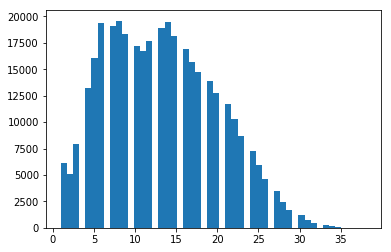

In [32]:
plot_histogram_length_of_utterances(utterances)
max_utterance_length = 40 # based on the histogram

Keras expects all utterances to be of the same length. Therefore we look at the distribution of lengths of utterances to determine what an appropriate maximum length should be. 

# Create a train test split of the data, in a format amenable to keras

In [33]:
word2idx = compute_word2idx(utterances)
tag2idx = compute_tag2idx(utterance_tokens)
groups2idx = compute_tag2idx(utterance_groups)
X = transform_utterances_for_keras(utterances, max_utterance_length, word2idx)
y = transform_tokens_for_keras(utterance_tokens, max_utterance_length, tag2idx)
z = transform_tokens_for_keras(utterance_groups, max_utterance_length, groups2idx)
X_tr, X_te, y_tr, y_te, z_tr, z_te = train_test(X, y, z)

# Define and compile the model

In [34]:
model = define_and_compile_model(max_utterance_length, len(word2idx), len(tag2idx), len(groups2idx))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 16)       2544        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 40, 16)       0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 40, 32)       4224        dropout_1[0][0]                  
__________________________________________________________________________________________________
token_outp

# Plot model training and analyze training

In [35]:
history = train_model(X_tr, y_tr, z_tr)

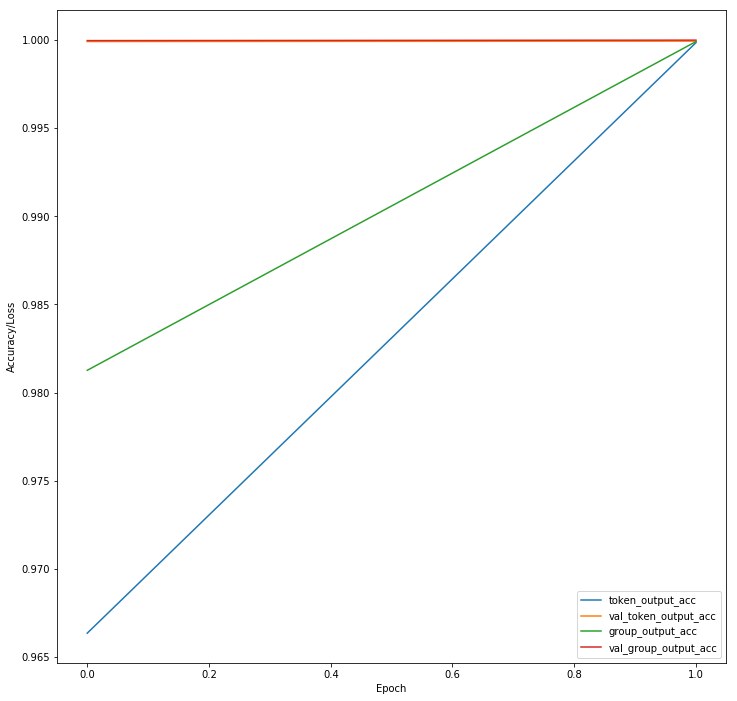

In [36]:
plot_model_training(history, 'acc')

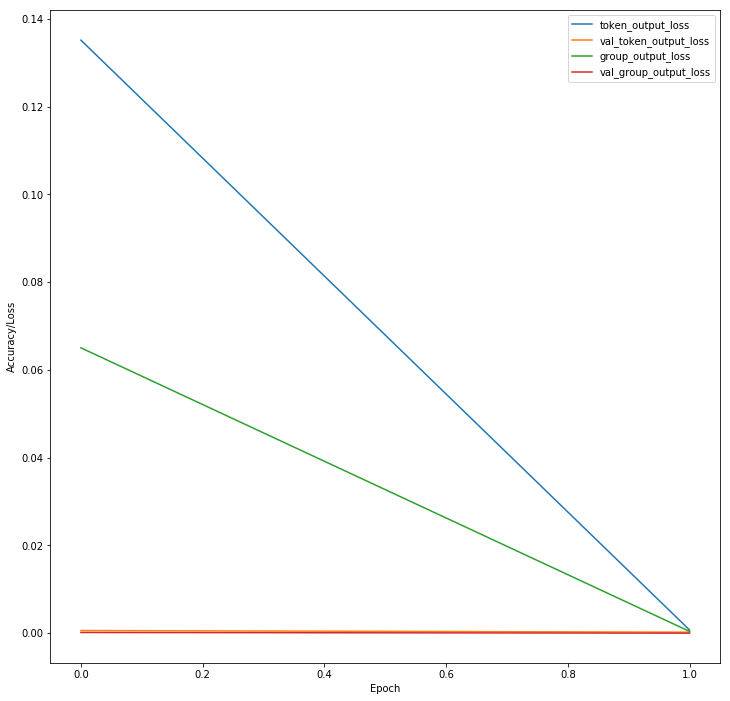

In [37]:
plot_model_training(history, 'loss')

Note: Here we can see that the model overfits the data from putput very quickly. This is both good and bad. It is good because it demonstrates that if you already have an existing model with this architecture, and you want to train it with utterances from putput, it is likely that the model has the capacity to learn the patterns well. It is bad because if you only have data from putput, the model will not generalize.

# Save and load model

In [38]:
if not os.environ.get('CI') and not putput_model_path.is_file():
    model.save('multiple_output_lstm_custom_word_emb.h5')

In [39]:
if not os.environ.get('CI') and putput_model_path.is_file():
    model = load_model('multiple_output_lstm_custom_word_emb.h5')

# Evaluate on test data

In [40]:
token_eval, group_eval = evaluate_model_on_test_split(model, X_te, y_te, z_te, tag2idx, groups2idx)

In [41]:
print(token_eval)

                            precision    recall  f1-score   support

                   PRONOUN       1.00      1.00      1.00      7792
                      ITEM       1.00      1.00      1.00    106312
               CONJUNCTION       1.00      1.00      1.00     28580
                       FOR       1.00      1.00      1.00      9213
    SUBSTITUTE_WITH_TARGET       1.00      1.00      1.00     14878
                       THE       1.00      1.00      1.00      7417
                  POSITION       1.00      1.00      1.00      3290
                       ADD       1.00      1.00      1.00     23042
                  QUANTITY       1.00      1.00      1.00     78828
              END_OF_ORDER       1.00      1.00      1.00      2478
               PRONOUN_ALL       1.00      1.00      1.00      1885
   PREPOSITION_TARGET_BACK       1.00      1.00      1.00      1872
                      SIZE       1.00      1.00      1.00      3916
                    REMOVE       0.99      0.99

In [42]:
print(group_eval)

             precision    recall  f1-score   support

        ADD       1.00      1.00      1.00     30107
     REMOVE       1.00      1.00      1.00     11290
 SUBSTITUTE       1.00      1.00      1.00     14878
       None       1.00      1.00      1.00     11545

avg / total       1.00      1.00      1.00     67820



# Make predictions

In [43]:
predict(model, 'three burger', max_utterance_length, word2idx, tag2idx, groups2idx, displacy_options)

In [44]:
predict(model, 'i want ten burger make that a chicken sandwich and remove one burger', max_utterance_length, word2idx, tag2idx, groups2idx, displacy_options)

In [45]:
predict(model, 'i want a chicken sandwich and remove one burger and she need to order french fries', max_utterance_length, word2idx, tag2idx, groups2idx, displacy_options)

In [46]:
predict(model, 'i want a chicken sandwich and ten ten chicken strips remove five french fries', max_utterance_length, word2idx, tag2idx, groups2idx, displacy_options)

In [47]:
predict(model, 'i want a chicken sandwich with coke actually make the chicken sandwich a hamburger and give me a burger', max_utterance_length, word2idx, tag2idx, groups2idx, displacy_options)